# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install pandas==1.0.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
print(pd.__version__)

1.0.5


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

### Data Cleaning and EDA

Total population dataset

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
azdias.shape

(891221, 366)

In [9]:
azdias.isnull().sum()/len(azdias)

LNR                     0.000000
AGER_TYP                0.000000
AKT_DAT_KL              0.082470
ALTER_HH                0.082470
ALTER_KIND1             0.909048
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.104517
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 366, dtype: float64

We can see that there are missing values present in a lot of columns, some columns have a high proportion of missing values. For example - `ALTER_KIND1`, `ALTER_KIND2`, `ALTER_KIND3`, `ALTER_KIND4` have more than 90% of their values as missing.

Let's list all the columns in the population dataset with more that 50% missing data.

In [10]:
azdias_na_proportions = azdias.isnull().sum()/len(azdias)

In [11]:
azdias_na_proportions[azdias_na_proportions > 0.5]

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
dtype: float64

We find that the columns `EXTSEL992` and `KK_KUNDENTYP` also have large proportion of missing values.

Let's explore the data type of the columns in the population dataset.

In [12]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

Let's explore the object types.

In [13]:
azdias_cat_cols = [col for col in azdias.columns if azdias[col].dtype==object]
azdias_cat_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [14]:
azdias[azdias_cat_cols].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


Let's explore these columns further.

In [15]:
print(azdias["CAMEO_DEU_2015"].nunique())
azdias["CAMEO_DEU_2015"].value_counts()

45


6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

Some values are `XX` which is not defined in the data dictionary. It can be assumed to be missing/undefined.

In [16]:
print(azdias["CAMEO_DEUG_2015"].nunique())
azdias["CAMEO_DEUG_2015"].value_counts()

19


8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

Some values are `X` which is not defined in the data dictionary. It can be assumed to be missing/undefined.

In [17]:
print(azdias["CAMEO_INTL_2015"].nunique())
azdias["CAMEO_INTL_2015"].value_counts()

43


51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

Again, we have `XX` present which can be assumed to be missing/undefined.

In [18]:
print(azdias["D19_LETZTER_KAUF_BRANCHE"].nunique())
azdias["D19_LETZTER_KAUF_BRANCHE"].value_counts()

35


D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN                  1646
D19_BANKEN

In [19]:
print(azdias["OST_WEST_KZ"].nunique())
azdias["OST_WEST_KZ"].value_counts()

2


W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [20]:
azdias_cat_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [21]:
azdias["EINGEFUEGT_AM"].head()

0                    NaN
1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
3    1997-04-21 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [22]:
azdias["EINGEFUEGT_AM"].isnull().sum()

93148

In [23]:
azdias.shape

(891221, 366)

`EINGEFUEGT_AM` is of object type but it contains values that can be treated as datetime.

Some observations from the above categorical columns in the population dataset.
* The `CAMEO_DEUG_2015`, `CAMEO_INTL_2015` columns are categorical fields storing categories as numeric values. 
* The `CAMEO_DEU_2015` and `CAMEO_INTL_2015` columns have an additional value `XX` while the column `CAMEO_DEUG_2015` has an additional value `X`, I'll assume it as missing or undefied.
* The `EINGEFUEGT_AM` columns stores the date information and would need to be converted to datetime.
* The `OST_WEST_KZ` column has only two unique values representing the two regions - W for west and O for east.

Also note that there are some columns in the customers dataframe that are not present in the population dataframe.

In [24]:
azdias_cols = azdias.columns
customers_cols = customers.columns
set(customers_cols)-set(azdias_cols)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

Let's now look at the customer dataset

Customers dataset

In [25]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [26]:
customers.shape

(191652, 369)

Proportion of missing value in each column.

In [27]:
customers.isnull().sum()/len(customers)

LNR                     0.000000
AGER_TYP                0.000000
AKT_DAT_KL              0.243128
ALTER_HH                0.243128
ALTER_KIND1             0.938607
                          ...   
PRODUCT_GROUP           0.000000
CUSTOMER_GROUP          0.000000
ONLINE_PURCHASE         0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 369, dtype: float64

Columns in the customers data with more than 50% missing values.

In [28]:
customers_na_proportions = customers.isnull().sum()/len(customers)
customers_na_proportions[customers_na_proportions > 0.5]

ALTER_KIND1     0.938607
ALTER_KIND2     0.973389
ALTER_KIND3     0.993347
ALTER_KIND4     0.998769
KK_KUNDENTYP    0.584064
dtype: float64

Similar to the population dataset, the customers dataset also has columns `ALTER_KIND1`, `ALTER_KIND2`, `ALTER_KIND3`, `ALTER_KIND4`, and `KK_KUNDENTYP` with more that 50% missing values.

Let's look at the missing value proportion for the `EXTSEL992` column.

In [29]:
customers_na_proportions["EXTSEL992"]

0.44498883392816146

Let's look at the column type distribution in the customers dataset.

In [30]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [31]:
customers_cat_cols = [col for col in customers.columns if customers[col].dtype==object]
customers_cat_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP']

In [32]:
customers[customers_cat_cols].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


We already know that the `PRODUCT_GROUP` and `CUSTOMER_GROUP` columns are specific to the customers dataset. Let's look at these categorical columns futher.

In [33]:
print(customers["CAMEO_DEU_2015"].nunique())
customers["CAMEO_DEU_2015"].value_counts()

45


2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

In [34]:
print(customers["CAMEO_DEUG_2015"].nunique())
customers["CAMEO_DEUG_2015"].value_counts()

19


2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [35]:
print(customers["CAMEO_INTL_2015"].nunique())
customers["CAMEO_INTL_2015"].value_counts()

43


14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

In [36]:
print(customers["D19_LETZTER_KAUF_BRANCHE"].nunique())
customers["D19_LETZTER_KAUF_BRANCHE"].value_counts()

35


D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_REST           3619
D19_BANKEN_DIREKT          3466
D19_LEBENSMITTEL           3053
D19_TELKO_REST             2303
D19_NAHRUNGSERGAENZUNG     2253
D19_TELKO_MOBILE           2131
D19_TECHNIK                1836
D19_BANKEN_GROSS           1684
D19_FREIZEIT               1672
D19_SAMMELARTIKEL          1610
D19_RATGEBER               1519
D19_KINDERARTIKEL          1439
D19_WEIN_FEINKOST          1424
D19_BANKEN_REST            1233
D19_BIO_OEKO                808
D19_REISEN                  666
D19_DIGIT_SERV              653
D19_GARTEN                  568
D19_HANDWERK                532
D19_BILDUNG                 357
D19_TIER

In [37]:
customers_cat_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP']

In [38]:
print(customers["OST_WEST_KZ"].nunique())
customers["OST_WEST_KZ"].value_counts()

2


W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [39]:
customers["EINGEFUEGT_AM"].isnull().sum()

49927

In [40]:
customers.shape

(191652, 369)

Let's look at the columns specific to the customers dataset - `CUSTOMER_GROUP`, `ONLINE_PURCHASE`, `PRODUCT_GROUP`

In [41]:
customer_only_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers[customer_only_cols].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD


In [42]:
print(customers["CUSTOMER_GROUP"].nunique())
customers["CUSTOMER_GROUP"].value_counts()

2


MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [43]:
print(customers["PRODUCT_GROUP"].nunique())
customers["PRODUCT_GROUP"].value_counts()

3


COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [44]:
print(customers["ONLINE_PURCHASE"].nunique())
customers["ONLINE_PURCHASE"].value_counts()

2


0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

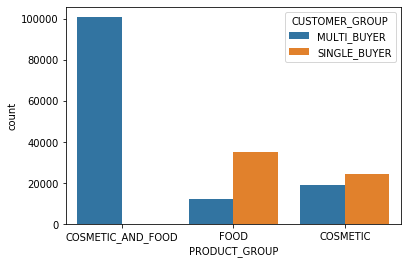

In [45]:
import seaborn as sns
sns.countplot(x="PRODUCT_GROUP", hue="CUSTOMER_GROUP", data=customers)

An interesting observation here is that customers in the "COSMETIC_AND_FOOD" product group almost exclusively are multi buyers.

After exploring both the population and the customers datasets, let's list down the data cleaning/preparation steps to apply - 
1. Remove the columns that are not present in both the datasets - `CUSTOMER_GROUP`, `PRODUCT_GROUP`, and, `ONLINE_PURCHASE`.
2. Remove columns with large proportion of missing values - `ALTER_KIND1`, `ALTER_KIND2`, `ALTER_KIND3`, `ALTER_KIND4`, `KK_KUNDENTYP`, `EXTSEL992`.
3. In the categorical column `CAMEO_DEUG_2015` replace `X` with null and in the columns `CAMEO_DEU_2015` and `CAMEO_INTL_2015` replace `XX` with nulls.
4. Impute missing values. For categorical columns, replace missing values with the mode and for the numerical columns replace missing values with the median.
5. Convert the `EINGEFUEGT_AM` to pandas datetime type.

In [46]:
cols_to_drop = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'EXTSEL992']
print(cols_to_drop)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'EXTSEL992']


In [47]:
print(customer_only_cols)

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


In [48]:
pop_cols = [col for col in azdias.columns if col not in cols_to_drop]
cust_cols = [col for col in customers.columns if col not in cols_to_drop+customer_only_cols]
print(len(pop_cols))
print(len(cust_cols))

360
360


In [49]:
print(set(pop_cols)==set(cust_cols))
print(len(pop_cols)==len(set(pop_cols)))

True
True


Let's create a function to apply the data cleaning and preprocessing steps mentioned above. This will give us a clean dataset to proceed with.

In [50]:
import numpy as np

def clean_data(df, cols_to_drop):
    # drop columns not required
    df = df.drop(cols_to_drop, axis=1)
    
    # replace 'X' in CAMEO_DEUG_2015 with NaN
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    
    # replace 'XX' in CAMEO_DEU_2015 and CAMEO_INTL_2015 with NaN
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    
    # impute missing values in categorical columns with mode
    df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)
    
    # impute missing values in numerical columns with median
    df.fillna(df.select_dtypes(include='number').median().iloc[0], inplace=True)
    
    # convert EINGEFUEGT_AM to datetime
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    
    return df

Apply the above function to clean the the population and the customers datasets.

In [51]:
print(cols_to_drop)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'EXTSEL992']


In [52]:
print(customer_only_cols)

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


In [53]:
azdias_df = clean_data(azdias, cols_to_drop)
# print the shape
print(azdias_df.shape)
# check of any missing values
print(azdias_df.isnull().sum().sum())

(891221, 360)
0


In [54]:
# display dtype counts 
azdias_df.dtypes.value_counts()

float64           261
int64              93
object              5
datetime64[ns]      1
dtype: int64

In [55]:
customers_df = clean_data(customers, cols_to_drop+customer_only_cols)
# print the shape
print(customers_df.shape)
# check of any missing values
print(customers_df.isnull().sum().sum())

(191652, 360)
0


In [56]:
# display dtype counts 
customers_df.dtypes.value_counts()

float64           261
int64              93
object              5
datetime64[ns]      1
dtype: int64

In [57]:
# # save dataframe for later use
# azdias_df.to_pickle('azdias_df.pkl')
# customers_df.to_pickle('customers_df.pkl')

### Feature Engineering

In this step we will - 
1. Extract additional features, if necessary.
2. One-hot encode the categorical columns.
3. Standardize the data with standard scaler.
4. Perform Perform PCA to reduce the data dimensionality.

We can extract the year, month, and day information from the datetime column `EINGEFUEGT_AM`

In [58]:
def add_temporal_features(df, date_col):
    # convert to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # extract temporal features
    df[date_col+"_Year"] = df[date_col].dt.year
    df[date_col+"_Month"] = df[date_col].dt.month
    df[date_col+"_Day"] = df[date_col].dt.day
    
    # drop the datetime column
    df = df.drop(date_col, axis=1)
    
    return df

In [59]:
azdias_df = add_temporal_features(azdias_df, 'EINGEFUEGT_AM')
customers_df = add_temporal_features(customers_df, 'EINGEFUEGT_AM')

One-hot encoding categorical features.

In [60]:
cat_cols = azdias_df.select_dtypes(include='object').columns.values
print(cat_cols)

['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']


In [61]:
print(customers_df.select_dtypes(include='object').columns.values)

['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'OST_WEST_KZ']


The `OST_WEST_KZ` feature has only two values - W and O which can be mapped to 1 and 0 respectively.

In [62]:
azdias_df['OST_WEST_KZ'] = azdias_df['OST_WEST_KZ'].map({'W': 1, 'O': 1})
customers_df['OST_WEST_KZ'] = customers_df['OST_WEST_KZ'].map({'W': 1, 'O': 1})

In [63]:
cat_cols = azdias_df.select_dtypes(include='object').columns.values
print(cat_cols)

['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE']


In [64]:
print(customers_df.select_dtypes(include='object').columns.values)

['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE']


Let's now one-hot encode the categorical features.

In [65]:
def encode_cat_features(df, cat_cols):
    # get one-hot encoded features
    dummies = pd.get_dummies(df[cat_cols])
    # concat the features
    df = pd.concat([df, dummies], axis=1)
    # drop the categorical features
    df = df.drop(cat_cols, axis=1)
    
    return df

In [66]:
# encode categorical features of population dataset
azdias_df = encode_cat_features(azdias_df, cat_cols)
azdias_df.dtypes.value_counts()

float64    261
uint8      139
int64       97
dtype: int64

In [67]:
# encode categorical features of customers dataset
customers_df = encode_cat_features(customers_df, cat_cols)
customers_df.dtypes.value_counts()

float64    261
uint8      139
int64       97
dtype: int64

Scale feature values. Scaling is an important step before applying PCA.

In [68]:
from sklearn.preprocessing import StandardScaler

# initialize the standard scaler
sc = StandardScaler()
# transform the population dataset
azdias_scaled_df = sc.fit_transform(azdias_df)

In [69]:
# transform the customers dataset
customers_scaled_df = sc.transform(customers_df)

Reduce dimensionality with PCA.

In [70]:
import matplotlib.pyplot as plt

def pca_scree_plot(pca):
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)

    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot()
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Cumulative explained variance ratio plot')

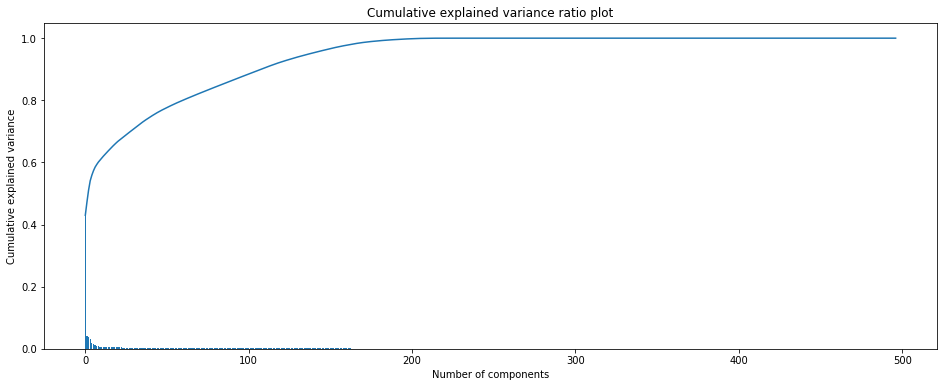

In [71]:
from sklearn.decomposition import PCA

# initialize the pca object
pca = PCA()
# fit pca object on the population data
pca.fit(azdias_scaled_df)
# display the PCA scree plot
pca_scree_plot(pca)

From the above figure we can use 150 as our target dimension since it covers most of the variance present in the data.

In [72]:
# reduce the populations dataset
pca_azdias = PCA(n_components=150)
# transform the population dataset
azdias_reduced_df = pd.DataFrame(pca.fit_transform(azdias_scaled_df))

In [73]:
# transform the customers dataset
customers_reduced_df = pd.DataFrame(pca.transform(customers_scaled_df))

In [74]:
# # save the recuded data for later use
# azdias_reduced_df.to_pickle("azdias_reduced_df.pkl")
# customers_reduced_df.to_pickle("customers_reduced_df.pkl")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Using K-means clustering to identify clusters (segments) in the data.  
Since, K is a hyperparameter, we will use the elbow method to find the optimal number of clusters to user. In this method, we plot the sum of squared distances of each data point to its nearest cluster aganist K. 

In [77]:
from sklearn.cluster import KMeans

sum_sq_error = []
k_ls = list(range(1, 21, 1))
print(k_ls)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Since our dataframe is large, we will use a random sampling of 20000 datapoints from the population dataset to find the optimal value of K. Later, we will use the full dataset with the optimal value of K for our clustering.

In [79]:
azdias_reduced_df.shape

(891221, 497)

In [80]:
# sample of the population dataset
azdias_sample = azdias_reduced_df.sample(20000, random_state=0)

for k in k_ls:
    print(k)
    km = KMeans(n_clusters=k)
    km.fit(azdias_sample)
    sum_sq_error.append(km.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


([<matplotlib.axis.XTick at 0x7fec7af7b650>,
 <a list of 20 Text xticklabel objects>)

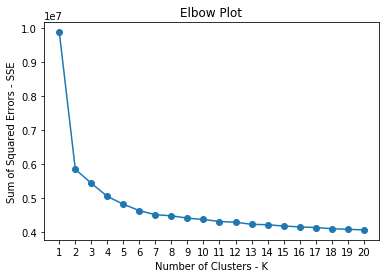

In [81]:
# plot SSE against K
plt.plot(k_ls, sum_sq_error, '-o')
plt.xlabel("Number of Clusters - K")
plt.ylabel("Sum of Squared Errors - SSE")
plt.title("Elbow Plot")
plt.xticks(list(range(1,21)))

We find an elbow at k=2. Although we found an elbow in the plot but using k=2 will only result in two clusters, to get a more granular segmentation let's use k=10.

Let's now segment our population and the customers datasets. For this we will -
* Initialize KMeans with K=10.
* Fit the alogrithm on the population dataset.
* Get the cluster for each datapoint in the population dataset.
* Use the same KMeans model to get the cluster value for each datapoint in the customers dataset.

In [82]:
# initialize the clustering model
kmeans_model = KMeans(n_clusters=10)
# fit the clustering algorithm on the population data
kmeans_model.fit(azdias_reduced_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [83]:
# get cluster predictions for the population set
azdias_clusters = pd.DataFrame(kmeans_model.predict(azdias_reduced_df), columns=['Cluster'])

In [84]:
# get cluster predictions for the customers set
customers_clusters = pd.DataFrame(kmeans_model.predict(customers_reduced_df), columns=['Cluster'])

In [85]:
# get count of values in each cluster
azdias_clusters = azdias_clusters['Cluster'].value_counts().sort_index()
azdias_clusters

0    141731
1     19531
2     73501
3    144699
4     33835
5      4854
6    223856
7     52718
8     32129
9    164367
Name: Cluster, dtype: int64

In [86]:
# get count of values in each cluster
customers_clusters = customers_clusters['Cluster'].value_counts().sort_index()
customers_clusters

0    57359
1      959
3    41104
6    83290
7     8940
Name: Cluster, dtype: int64

In [87]:
# create a dataframe of cluster info
cluster_info = pd.concat([azdias_clusters, customers_clusters], axis=1)
cluster_info.columns = ["Population", "Customers"]
cluster_info

,Population,Customers
0,141731,57359.0
1,19531,959.0
2,73501,NaN
3,144699,41104.0
4,33835,NaN
5,4854,NaN
6,223856,83290.0
7,52718,8940.0
8,32129,NaN
9,164367,NaN


In [88]:
# convert counts to proportions
for col in ["Population", "Customers"]:
    cluster_info[col] = cluster_info[col]/cluster_info[col].sum()
cluster_info

,Population,Customers
0,0.159030,0.299287
1,0.021915,0.005004
2,0.082472,NaN
3,0.162360,0.214472
4,0.037965,NaN
5,0.005446,NaN
6,0.251179,0.434590
7,0.059153,0.046647
8,0.036051,NaN
9,0.184429,NaN


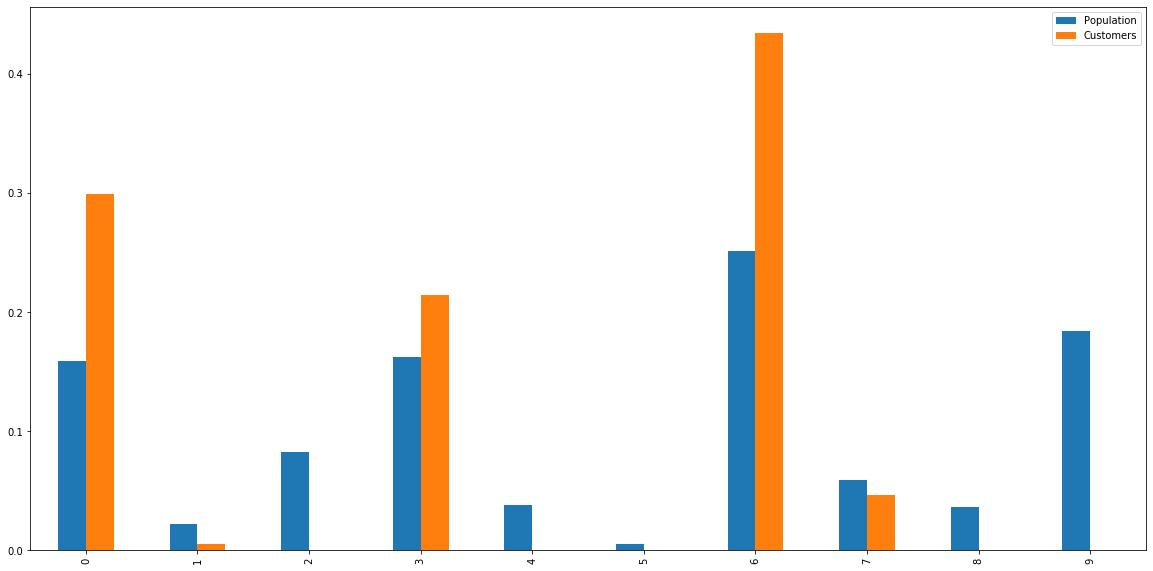

In [89]:
cluster_info.plot(kind='bar', figsize=(20, 10))

We can see that the datapoints in clusters 0, 1, 3, 6, and 7 share common characteristics between the population and the customers dataset. This can imply that these clusters carry characteristics that can help us better identify customers from general population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [90]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [91]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [92]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [93]:
azdias.shape

(891221, 366)

In [94]:
set(mailout_train.columns)-set(azdias.columns)

{'RESPONSE'}

The dataset has all the columns from the general population dataset (azdias) along with one additional column `RESPONSE` which is the target value to predict in the classification task.

Let's look at the class distribution of the target variable.

In [95]:
# distribution of the response
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

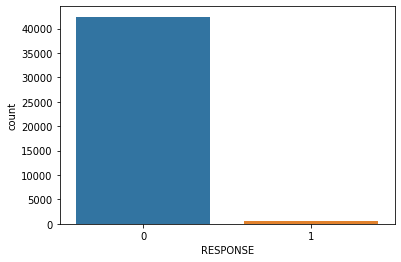

In [96]:
import seaborn as sns
sns.countplot(mailout_train['RESPONSE'])

The data is skewed with majority of datapoints belonging to the non-customer class.

### Data Cleaning and Preprocessing

In this step we will,
* Separate the target from the data
* Clean the data and perform feature engineering using the same methods used for the population dataset above.

In [97]:
# let's separate the target variable from the dataset
target = mailout_train['RESPONSE']
mailout_train = mailout_train.drop('RESPONSE', axis=1)

In [98]:
set(mailout_train.columns)==set(azdias.columns)

True

In [99]:
# distribution of data types
mailout_train.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

Data Cleaning and imputation

In [100]:
cols_to_drop = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'EXTSEL992']

In [101]:
print(cols_to_drop)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP', 'EXTSEL992']


In [102]:
mailout_train = clean_data(mailout_train, cols_to_drop)
# print the shape
print(mailout_train.shape)
# check of any missing values
print(mailout_train.isnull().sum().sum())

(42962, 360)
0


Add temporal features

In [103]:
# add temporal features
mailout_train = add_temporal_features(mailout_train, 'EINGEFUEGT_AM')
mailout_train.shape

(42962, 362)

In [104]:
# map the binary feature OST_WEST_KZ
mailout_train['OST_WEST_KZ'] = mailout_train['OST_WEST_KZ'].map({'W': 1, 'O': 1})

Drop categorical columns

In [105]:
cat_cols = mailout_train.select_dtypes(include='object').columns.values
print(cat_cols)

['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE']


In [106]:
# # encode categorical features of population dataset
# mailout_train = encode_cat_features(mailout_train, cat_cols)
# mailout_train.dtypes.value_counts()

In [107]:
# drop categorical features of population dataset
mailout_train = mailout_train.drop(cat_cols, axis=1)
mailout_train.dtypes.value_counts()

float64    261
int64       97
dtype: int64

In [108]:
from sklearn.preprocessing import StandardScaler

In [109]:
# scale data with standard scaler
# initialize the standard scaler
sc = StandardScaler()
# transform the population dataset
mailout_train_scaled = pd.DataFrame(sc.fit_transform(mailout_train), columns=mailout_train.columns)

Split the data into training and validation sets.

In [110]:
from sklearn.model_selection import train_test_split

X = mailout_train_scaled
y = target

# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [111]:
X_train.shape

(30073, 358)

In [112]:
X_val.shape

(12889, 358)

### Traning Model and check performance on the test set

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

First, we will train our baseline model. We will be using Logistic Regression as our baseline model.

### Logistic Regression Model

In [114]:
# initialize the model
lr = LogisticRegression(max_iter=5000)
# fit the model on the train set
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
# predict on the validation set
y_pred = lr.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.0
ROC AUC Score: 0.5


### Decision Tree Model

In [116]:
# initialize the model
dtree = DecisionTreeClassifier()
# fit the model on the train set
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [117]:
# predict on the validation set
y_pred = dtree.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.05221932114882507
ROC AUC Score: 0.5227278050837201


### Random Forest Model

In [118]:
# initialize the model
rf = RandomForestClassifier()
# fit the model on the train set
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [119]:
# predict on the validation set
y_pred = rf.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.0
ROC AUC Score: 0.49921433060967946


#### Gradient Boosting

In [120]:
# initialize the model
gb = GradientBoostingClassifier()
# fit the model on the train set
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [121]:
# predict on the validation set
y_pred = gb.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.0
ROC AUC Score: 0.4997250157133878


We get very low (almost zero) F1-Score for all these models because the recall of the model is very bad due to the data being very heavily skewed.

Also, the model performance for models such as DecisionTree, Random Forest, and Gradient Boosting doesn't beat the baseline performance of the logistic regression model.

### Project Improvement

The performance of the models above is not very encouraging. The primary reason for this is the heavy imbalance present in the data. We can address this imbalace with methods like - Upsampling, downsampling, SMOTE, etc.

In [122]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

We notice that the class 1 (converted customer) has very low number of datapoints compared to class 0. This high imbalance can be the reason for the poor performance from the models used above.

Let's use upsampling to tackle this problem. In this method, we generate artificial samples of the minority class (class 1 in our case) to make the dataset more balanced. We can then train the model on this balaced dataset and check its performance on the test set.

To prevent any data leakage, we will leave the test set as is and will only up-sample the minority class in the train set and then train models on this set.

In [123]:
# train set
X_train.shape

(30073, 358)

In [124]:
y_train.value_counts()

0    29702
1      371
Name: RESPONSE, dtype: int64

In [125]:
# join the label for the train set
train_df = X_train.copy()
train_df['RESPONSE'] = y_train
train_df.shape

(30073, 359)

In [126]:
# split the data for each class
train_df_1 = train_df[train_df['RESPONSE']==1]
print(train_df_1.shape)
train_df_0 = train_df[train_df['RESPONSE']==0]
print(train_df_0.shape)

(371, 359)
(29702, 359)


Let's now upsample the minority class.

In [127]:
from sklearn.utils import resample, shuffle

# upsample minority class
train_df_1_upsampled = resample(train_df_1, random_state=0, n_samples=29702, replace=True)
print(train_df_1_upsampled.shape)

(29702, 359)


In [128]:
train_df_1_upsampled.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_Year,EINGEFUEGT_AM_Month,EINGEFUEGT_AM_Day,RESPONSE
41851,0.993939,1.031262,-0.440057,-0.440042,-0.484028,-0.470487,-0.487371,-0.440029,-0.440025,-0.470461,...,-0.539147,-0.440007,-0.469961,0.174577,-1.212290,0.736410,-0.359851,-0.360411,0.133961,1
40402,-0.469654,-1.092019,2.272604,2.272604,2.065957,2.127025,2.051839,2.272604,2.272604,2.127025,...,1.854492,2.272604,2.127026,0.174577,-1.212290,-0.200391,-0.359851,-0.360411,-0.326348,1
38199,1.115256,-1.092019,2.272604,2.272604,2.065957,2.127025,2.051839,2.272604,2.272604,2.127025,...,1.854492,2.272604,2.127026,0.174577,-1.212290,-2.073993,-0.359851,-0.360411,-0.326348,1
14912,-1.258417,1.031262,-0.440057,-0.440677,-0.484148,-0.470426,-0.487371,-0.439966,-0.440025,-0.470400,...,-0.539427,-0.440007,-0.469961,1.066183,0.824885,0.736410,-0.359851,-0.360411,0.133961,1
26061,0.900631,0.323502,-0.440057,-0.440677,-0.484028,-0.470487,-0.487371,-0.439966,-0.440025,-0.470461,...,-0.539427,-0.440007,-0.470265,-1.608634,-1.212290,0.736410,-0.359851,-0.360411,-0.326348,1


Let's now get the balanced train data together.

In [129]:
# combine data to get balanced train set
train_df_upsampled = pd.concat([train_df_0, train_df_1_upsampled])
print(train_df_upsampled.shape)

(59404, 359)


In [130]:
train_df_upsampled['RESPONSE'].value_counts()

1    29702
0    29702
Name: RESPONSE, dtype: int64

In [131]:
# separate data and labels
y_train_upsampled = train_df_upsampled['RESPONSE']
X_train_upsampled = train_df_upsampled.drop('RESPONSE', axis=1)
print(X_train_upsampled.shape)

(59404, 358)


Now that we have our balanced data, let's go ahead and train our models -
* Logistic Regression (Baseline)
* Decision Tree
* Random Forest

#### Logistic Regression

In [132]:
# initialize the model
lr = LogisticRegression(max_iter=5000)
# fit the model on the train set
lr.fit(X_train_upsampled, y_train_upsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
# predict on the validation set
y_pred = lr.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.037642192347466394
ROC AUC Score: 0.6025725548602192


The performance of the base model - Logistic Regression improved by upsampling the minority class.

#### Decision Tree

In [134]:
# initialize the model
dtree = DecisionTreeClassifier()
# fit the model on the train set
dtree.fit(X_train_upsampled, y_train_upsampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [135]:
# predict on the validation set
y_pred = dtree.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.012307692307692308
ROC AUC Score: 0.49984725806262714


#### Random Forest

In [136]:
# initialize the model
rf = RandomForestClassifier()
# fit the model on the train set
rf.fit(X_train_upsampled, y_train_upsampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [137]:
# predict on the validation set
y_pred = rf.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.0
ROC AUC Score: 0.4991750471401634


Not much effect on the performance of Decision Tree and Random Forest when using upsampling.

Let's try a gradient boosting model.

#### Gradient Boosting

In [138]:
# initialize the model
gb = GradientBoostingClassifier()
# fit the model on the train set
gb.fit(X_train_upsampled, y_train_upsampled)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [139]:
# predict on the validation set
y_pred = gb.predict(X_val)
# f1-score on the validation set
print(f"F1 Score: {f1_score(y_val, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred)}")

F1 Score: 0.06712378202814868
ROC AUC Score: 0.6899433830045559


We get a **considerable improvement with upsampling of the minority class** for the Logistic Regression and the Gradient Boosting models. Also, the Gradient Boosting model beats the performance of the baseline Logistic Regression model. Thus, using a Gradient Boosting model on upsampled data is the recommended method for this project.

### Comparing results of the baseline with the final model

We use a Logistic Regression model as our baseline. In the above step, we found Gradient Boosting with minority class upsampling beat the performance of the baseline. Let's compare the results for the two models.

The following is comparison of the baseline (Logistic Regression) model against the gradient boosting model on data without any upsampling of the minority class.

|Model |F1-Score|ROC AUC|
|------|--------|-------|
|Baseline (Logistic Regression)|0.0|0.5|
|Gradient Boosting|0.0|0.499|

The following is comparison of the baseline (Logistic Regression) model against the gradient boosting model on data after upsampling of the minority class, as shown in the Project Improvement section.

|Model |F1-Score|ROC AUC|
|------|--------|-------|
|Baseline (Logistic Regression)|0.037|0.602|
|Gradient Boosting|0.067|0.689|

We're still getting low values for F1-Score (due to low recall resulting from high data imbalance) but the ROC AUC of the model considerably improved with using upsampling.